<a href="https://colab.research.google.com/github/hyang0129/food-class-app/blob/main/FOODTRAINER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

In [ ]:
!pip install -q einops
!pip install --upgrade tensorflow_addons
!pip install -q efficientnet

Requirement already up-to-date: tensorflow_addons in /usr/local/lib/python3.6/dist-packages (0.12.1)


In [ ]:
import math, re, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
import cv2
import tensorflow_addons as tfa
import PIL
import tensorflow.keras.backend as K
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from einops import rearrange
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn

In [ ]:
import os
assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

import tensorflow as tf
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)


TPU address is grpc://10.55.16.218:8470
Running on TPU  grpc://10.55.16.218:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.55.16.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.55.16.218:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# HYPER PARAMETERS

In [ ]:
class P():
    epochs = 20
    net_input_dim = (256, 256, 3) 
    batch_size = 1024
    num_train_img = 75750 * 2
    shuffle_buffer_size = 1024 * 4
    mean = [103.939, 116.779, 123.68]
    std = [58.393, 57.12, 57.375]
    num_class = 101
    initial_learning_rate = 0.002
    minimum_learning_rate = 0.0001
    epoch_num = epochs 
    iterations_per_epoch = num_train_img / batch_size
    steps_per_epoch = iterations_per_epoch
    warm_iterations = iterations_per_epoch * 2
    architecture = 'ef' # ef
    image_size_pre_augment = 320
    model_save_path =  '/content/drive/Shared drives/KAGGLE/FOODCLASS/'
    model_name = 'B3_FOODCLASS'


# DATASET DEFINITION

## AUGMENTATION

In [ ]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image):    
    DIM = P.image_size_pre_augment
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = 180 * tf.random.normal([1], dtype='float32')
    shr = 1.0 * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / 8.0
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / 8.0
    h_shift = 8.0 * tf.random.normal([1], dtype='float32') 
    w_shift = 8.0 * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

def dropout(image, DIM=256, PROBABILITY = 0.75, CT = 8, SZ = 0.2):
    # input - one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed

    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1) < PROBABILITY, tf.int32)
    if (P == 0)|(CT == 0)|(SZ == 0): return image

    for k in range( CT ):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        # COMPUTE SQUARE 
        WIDTH = tf.cast( SZ*DIM,tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3]) 
        three = image[ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)

    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR 
    image = tf.reshape(image,[DIM,DIM,3])
    return image


def augment_image(example):

    image = example['image']

    image = tf.image.resize_with_pad(image, P.image_size_pre_augment, P.image_size_pre_augment)
    image = transform(image)
    image = tf.image.random_crop(image, P.net_input_dim)
    image = tf.image.random_flip_left_right(tf.image.random_flip_up_down(image))
    image = dropout(image)

    example['image'] = image 

    return example

def process_image(example):

    image = example['image']
    image = tf.image.resize_with_pad(image, P.net_input_dim[0] , P.net_input_dim[1])
    # image = tf.image.central_crop(image, 0.875)
    # image = tf.image.resize_with_pad(image, P.net_input_dim[0], P.net_input_dim[1])

    example['image'] = image 

    return example 

def normalize(example): 
    image = example['image']
    image = tf.cast(image, tf.float32)

    # image = image - P.mean 
    # image = image / P.std

    image = image/255.
    example['image'] = image 
    return example 

def compress(example):

    image = example['image']
    image = tf.cast(image, tf.float32)
    image = image/255.
    image = tf.image.resize_with_pad(image, 256,256)
    image = tf.cast(image * 255., tf.uint8)

    example['image'] = tf.io.encode_jpeg(image)
    return example

def decompress(example):
    example['image'] = tf.image.decode_jpeg(example['image'])
    return example

def to_bfloat16(example):
    example['image'] = tf.cast(example['image'], dtype = 'bfloat16')
    return example 
    
def to_onehot(example):

    example['label'] = tf.one_hot(example['label'], P.num_class)
    return example 



## DATASET PREPARATION

In [ ]:

def get_dataset(ds, augment = False, shuffle = P.shuffle_buffer_size, batch = P.batch_size, repeat = False, to_xy =False, cache_big = False, mixed_p = False, cache = False): 

    if cache_big:
        ds = ds.map(compress, num_parallel_calls = -1)
        ds = ds.cache()
        ds = ds.map(decompress, num_parallel_calls = -1)
        
    ds = ds.repeat() if repeat else ds 
    ds = ds.map(normalize, num_parallel_calls = -1)
    ds = ds.cache() if cache else ds 
    ds = ds.map(augment_image, num_parallel_calls = -1) if augment else ds.map(process_image)
    ds = ds.map(to_bfloat16, num_parallel_calls = -1) if mixed_p else ds 
    ds = ds.map(to_onehot, num_parallel_calls = -1)
    ds = ds.shuffle(shuffle) if shuffle else ds 
    ds = ds.map(lambda x : (x['image'], x['label'])) if to_xy else ds 
    ds = ds.batch(batch) if batch else ds 
    ds = ds.prefetch(-1)

    return ds 


    
ds_train, ds_valid = tfds.load(name="food101", 
                              split=["train", "validation"], 
                              data_dir="gs://kaggledata2/", 
                              builder_kwargs={"version": "2.0.0"},)



In [ ]:
ds  = get_dataset(ds_train, augment = True , shuffle = False, repeat = True)
ds

<PrefetchDataset shapes: {image: (None, 256, 256, 3), label: (None, 101)}, types: {image: tf.float32, label: tf.float32}>

## DATA SAMPLES

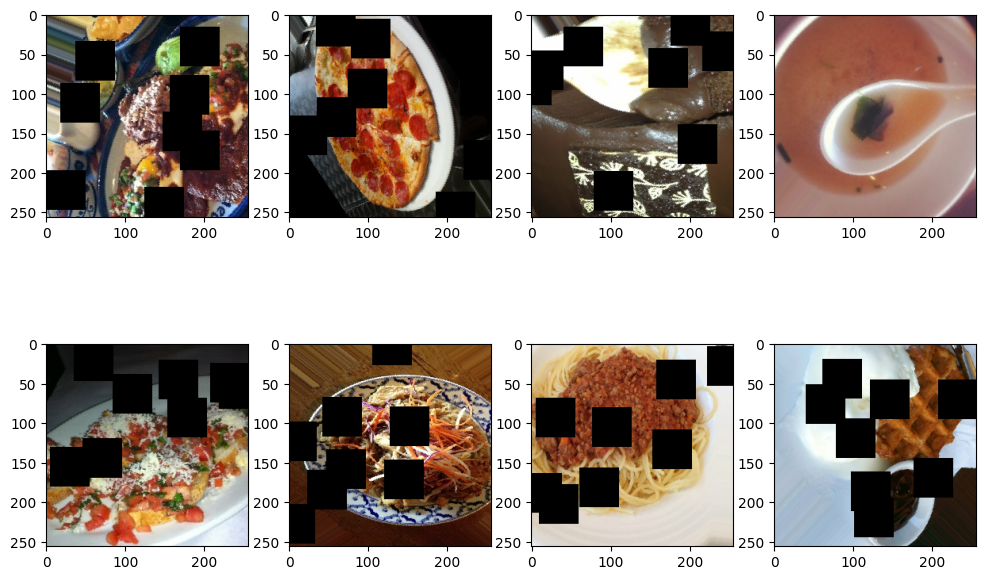

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

ds  = get_dataset(ds_train, augment = True , shuffle = False, repeat = True)


def draw_grid(imgs, nrow, ncol):

    fig, axs = plt.subplots(nrows=nrow, ncols=ncol)

    for i, ax in enumerate(axs.reshape(-1)):

        img = imgs[i].numpy()
        
        ax.imshow(img)
        

draw_grid(list(ds.take(1))[0]['image'][:8], 2, 4)


# list(ds.take(1))[0][1][:8]



# MODEL DEFINITION

## LOSS

In [ ]:
def get_loss():

    # return tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2)

    def smoothfocal(y_true, y_pred): 
        smooth = 0.1
        y_true = y_true * (1 - smooth) + smooth/P.num_class

        return tfa.losses.sigmoid_focal_crossentropy(y_true, y_pred)

    return smoothfocal



## OPTIMIZER

In [ ]:
class CosineDecayWithWarmUP(tf.keras.experimental.CosineDecay):
    def __init__(self, initial_learning_rate, decay_steps, alpha=0.0, warm_up_step=0, name=None):
        self.warm_up_step = warm_up_step
        super(CosineDecayWithWarmUP, self).__init__(initial_learning_rate=initial_learning_rate,
                                                    decay_steps=decay_steps,
                                                    alpha=alpha,
                                                    name=name)

    @tf.function
    def __call__(self, step):
        if step <= self.warm_up_step:
            return step / self.warm_up_step * self.initial_learning_rate
        else:
            return super(CosineDecayWithWarmUP, self).__call__(step - self.warm_up_step)


def get_optimizer():

    learning_rate_schedules = CosineDecayWithWarmUP(initial_learning_rate= P.initial_learning_rate,
                                                    decay_steps= P.epoch_num * P.iterations_per_epoch - P.warm_iterations,
                                                    alpha=P.minimum_learning_rate,
                                                    warm_up_step=P.warm_iterations)
    
    # optimizer = tfa.optimizers.SGDW(learning_rate=learning_rate_schedules, momentum=0.9, weight_decay = 1e-4)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedules)

    return optimizer 


## TRAINING DEFINITION

In [ ]:
def get_model():

    with strategy.scope():
            
        model = efn.EfficientNetB3(weights = 'imagenet', 
                                            input_shape=P.net_input_dim,
                                            include_top = False,
                                            )
        
        out = model.output 
        out = L.GlobalAvgPool2D()(out)
        out = L.Dropout(0.5)(out)
        out = L.Dense(P.num_class, activation='softmax')(out)

        model = tf.keras.Model(inputs = {'image' : model.input}, outputs = {'label' : out})

        loss = get_loss()
        opt = get_optimizer()

        metrics = [tf.keras.metrics.CategoricalAccuracy()]

        model.compile(opt, loss, metrics)

    return model 

    

class Saver(tf.keras.callbacks.Callback): 
    
    def __init__(self, model_name): 
        super().__init__()
        self.model_name = model_name 
    
    def on_epoch_end(self, epoch, logs=None):            
        lpath = P.model_save_path + self.model_name + '_e{:03}'.format(epoch)  + '.h5'
        self.model.save(lpath, include_optimizer=True)


# TRAINING

In [ ]:

ds_train, ds_valid = tfds.load(name="food101", 
                              split=["train", "validation"], 
                              data_dir="gs://kaggledata2/", 
                              builder_kwargs={"version": "2.0.0"},)


ds_train = get_dataset(ds_train, augment=True, repeat=True, to_xy=True)
ds_valid = get_dataset(ds_valid, shuffle=False, to_xy=True).cache()

model = get_model()


saver = Saver(P.model_name)
csvlog =  tf.keras.callbacks.CSVLogger(P.model_save_path + P.model_name + '.csv')


history = model.fit(ds_train,
            steps_per_epoch  = P.steps_per_epoch,
            epochs           = P.epochs, 
            validation_data = ds_valid,
            callbacks = [saver, csvlog],
            verbose = 1)




Epoch 1/20
  6/147 [>.............................] - ETA: 1:52 - loss: 1.0250 - categorical_accuracy: 0.0127WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0083s vs `on_train_batch_end` time: 10.4344s). Check your callbacks.


147/147 [==============================] - 262s 1s/step - loss: 0.8550 - categorical_accuracy: 0.1338 - val_loss: 0.2945 - val_categorical_accuracy: 0.6108
Epoch 2/20
147/147 [==============================] - 143s 967ms/step - loss: 0.2874 - categorical_accuracy: 0.6288 - val_loss: 0.2983 - val_categorical_accuracy: 0.6280
Epoch 3/20
147/147 [==============================] - 136s 920ms/step - loss: 0.2368 - categorical_accuracy: 0.6888 - val_loss: 0.2533 - val_categorical_accuracy: 0.6929
Epoch 4/20
147/147 [==============================] - 131s 888ms/step - loss: 0.1976 - categorical_accuracy: 0.7357 - val_loss: 0.1909 - val_categorical_accuracy: 0.7505
Epoch 5/20
147/147 [==============================] - 129s 871ms/step - loss: 0.1753 - categorical_accuracy: 0.7646 - val_loss: 0.1552 - val_categorical_accuracy: 0.7980
Epoch 6/20
147/147 [==============================] - 132s 895ms/step - loss: 0.1538 - categorical_accuracy: 0.7909 - val_loss: 0.1570 - val_categorical_accuracy: 0

In [ ]:
import glob 

glob.glob(P.model_save_path + '*.h5')

['/content/drive/Shared drives/KAGGLE/FOODCLASS/B3_FOODCLASS_e000.h5',
 '/content/drive/Shared drives/KAGGLE/FOODCLASS/B3_FOODCLASS_e001.h5',
 '/content/drive/Shared drives/KAGGLE/FOODCLASS/B3_FOODCLASS_e002.h5',
 '/content/drive/Shared drives/KAGGLE/FOODCLASS/B3_FOODCLASS_e003.h5',
 '/content/drive/Shared drives/KAGGLE/FOODCLASS/B3_FOODCLASS_e004.h5',
 '/content/drive/Shared drives/KAGGLE/FOODCLASS/B3_FOODCLASS_e005.h5',
 '/content/drive/Shared drives/KAGGLE/FOODCLASS/B3_FOODCLASS_e006.h5',
 '/content/drive/Shared drives/KAGGLE/FOODCLASS/B3_FOODCLASS_e007.h5',
 '/content/drive/Shared drives/KAGGLE/FOODCLASS/B3_FOODCLASS_e008.h5',
 '/content/drive/Shared drives/KAGGLE/FOODCLASS/B3_FOODCLASS_e009.h5',
 '/content/drive/Shared drives/KAGGLE/FOODCLASS/B3_FOODCLASS_e010.h5',
 '/content/drive/Shared drives/KAGGLE/FOODCLASS/B3_FOODCLASS_e011.h5',
 '/content/drive/Shared drives/KAGGLE/FOODCLASS/B3_FOODCLASS_e012.h5',
 '/content/drive/Shared drives/KAGGLE/FOODCLASS/B3_FOODCLASS_e013.h5',
 '/con

In [ ]:

from google.cloud import storage
storage_client = storage.Client.from_service_account_json('/content/drive/My Drive/kaggle/gckey.json')

def upload_blob(source_file_name):
    bucket = storage_client.bucket('kaggledata2')
    blob = bucket.blob('foodclass/' + 'model.h5')
    blob.upload_from_filename(source_file_name)

# upload_blob('/content/drive/Shared drives/KAGGLE/FOODCLASS/B3_FOODCLASS_e005.h5')